In [1]:
library(magrittr)
library(tibble)
library(gutenbergr)
library(dplyr)
library(tidytext)
library(ggplot2)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
✔ purrr   0.3.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


In [47]:
#downloading same titles in english and french
booksIdEn <- c(1268, 965, 83, 103, 164, 1608, 1257, 11656, 174, 887)

booksIdFr <- c(799, 800, 5097, 14287, 2419, 19951, 26504, 13735, 14192, 51236)

booksIdFrUtf <- c(799, 5097, 14287, 2419, 13951, 13735, 51236)
booksIdFrLatin <- c(800, 26504, 14192)

#function for calculating heap law
heap <- function(booksId, latin1=0, shuffle=0) {
    g <- gutenberg_metadata
    v <- gutenberg_download(booksId) 
    books <- g[g$gutenberg_id %in% booksId,c("gutenberg_id","title")]
    v %<>% left_join(books) %>%
        mutate(gutenberg_id = NULL)
    
    if (latin1 == 1) { #convert latin1 to utf8
        v <- v  %>% 
        map( iconv , from = "ISO-8859-1", to = "UTF-8") %>%
        as.tibble()
    }

    heaps <- v %>%
        unnest_tokens(word, text) %>%
        group_by(title) 
    
    if (shuffle==1) { #shuffle words
        heaps <- heaps[sample(nrow(heaps)),]
    }
    
    heaps <- heaps %>%
        mutate(M = row_number(), V = cumsum(!duplicated(word))) %>%
        summarise(a = lm(log10(V) ~ log10(M))$coefficients[1], b = lm(log10(V) ~ log10(M))$coefficients[2])
    return(heaps)
    
}


In [48]:
heapEn <- heap(booksIdEn)

Joining, by = "gutenberg_id"


In [49]:
heapEn

title,a,b
<chr>,<dbl>,<dbl>
Around the World in Eighty Days,0.9413029,0.6097285
Camille (La Dame aux Camilias),0.9871081,0.5593476
"From the Earth to the Moon; and, Round the Moon",1.0072582,0.5942153
Intentions,0.7039077,0.6734698
The Black Tulip,0.9023068,0.6023513
The Great Shadow and Other Napoleonic Tales,0.8190358,0.6187732
The Mysterious Island,1.2380574,0.5262701
The Picture of Dorian Gray,0.8918521,0.6069944
The Three Musketeers,1.2408291,0.5245780


In [38]:
heapFr <- rbind(heap(booksIdFrUtf), heap(booksIdFrLatin, 1))

Joining, by = "gutenberg_id"
Joining, by = "gutenberg_id"


In [39]:
heapFr

title,a,b
<chr>,<dbl>,<dbl>
De la Terre à la Lune,0.7286914,0.6705959
Intentions,0.6047117,0.7139094
L'île mystérieuse,0.8574821,0.6353487
La dame aux camélias,0.8420506,0.6290949
La grande ombre,0.7448636,0.6634422
Les trois mousquetaires,1.0377447,0.5908892
Vingt mille Lieues Sous Les Mers — Complete,0.7918664,0.6675353
La tulipe noire,0.7418128,0.6641498
Le portrait de Dorian Gray,0.5592756,0.7084103


In [41]:
dfEn <- as.data.frame(heapEn) %>%
    add_column(language = "en")

#dataframe with english order
englishOrder <- c("Le tour du monde en quatre-vingts jours", "La dame aux camélias", "De la Terre à la Lune", 
        "Intentions", "La tulipe noire", "La grande ombre", "L\'île mystérieuse", "Le portrait de Dorian Gray", "Les trois mousquetaires",
        "Vingt mille Lieues Sous Les Mers — Complete")
englishOrderDf <- as.data.frame(englishOrder)
colnames(englishOrderDf) <- c("title")

#df with french results
dfFr <- as.data.frame(heapFr) %>%
    add_column(language = "fr") 
dfFr <-  left_join(englishOrderDf,dfFr,by="title")
#total results
df <- rbind(dfEn, dfFr)
df

title,a,b,language
<chr>,<dbl>,<dbl>,<chr>
Around the World in Eighty Days,0.7394671,0.6532877,en
Camille (La Dame aux Camilias),1.0612123,0.5454732,en
"From the Earth to the Moon; and, Round the Moon",0.9548350,0.6068525,en
Intentions,0.6856043,0.6769286,en
The Black Tulip,0.8978457,0.6039249,en
The Great Shadow and Other Napoleonic Tales,0.7409080,0.6288367,en
The Mysterious Island,1.0906852,0.5520328,en
The Picture of Dorian Gray,0.7400915,0.6347603,en
The Three Musketeers,1.2600071,0.5193619,en


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Vingt mille Lieues Sous Les Mers — Complete' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Vingt mille Lieues Sous Les Mers — Complete' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Vingt mille Lieues Sous Les Mers — Complete' in 'mbcsToSbcs': dot substituted for <94>”


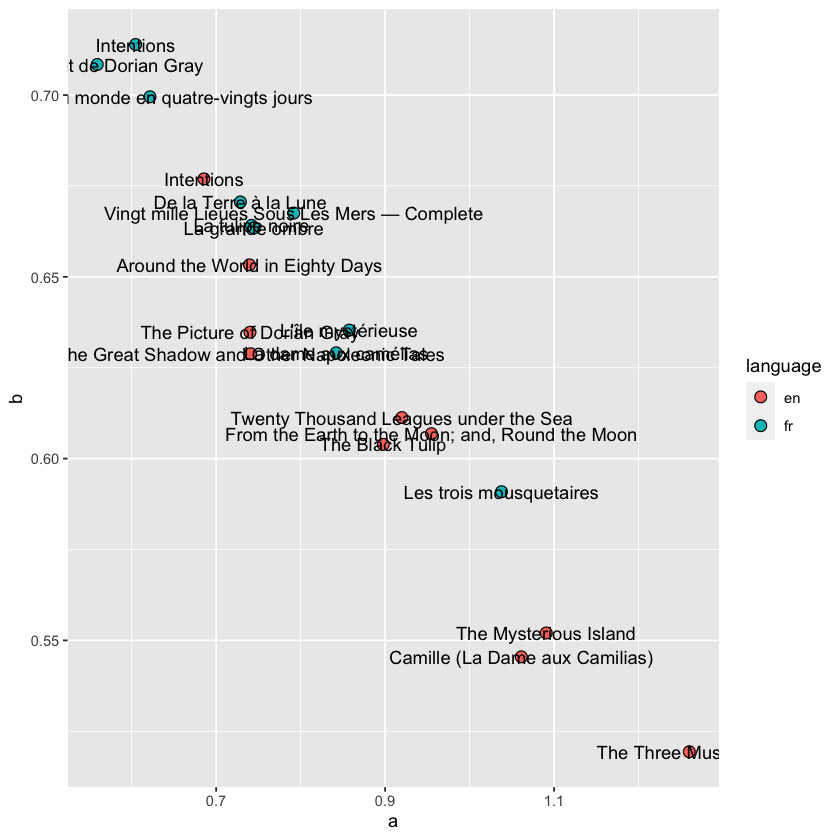

In [42]:
ggplot(df, aes(x = a, y = b, fill = language, label=title)) +
geom_point(size =3, shape=21) + 
geom_text()

In [43]:
cor.test(df[df$language == "en",]$b, df[df$language == "fr",]$b, method=c("pearson"))


	Pearson's product-moment correlation

data:  df[df$language == "en", ]$b and df[df$language == "fr", ]$b
t = 9.2083, df = 8, p-value = 1.566e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8195782 0.9898086
sample estimates:
     cor 
0.955922 


Obserwujemy korelacje między językami;

Dla pomieszanych danych:

In [50]:
#shuffled
#en results
heapEn <- heap(booksIdEn, shuffle=1)

dfEn <- as.data.frame(heapEn) %>%
    add_column(language = "en")
heapEn <- heap(booksIdEn, shuffle=1)
#fr results
heapFr <- rbind(heap(booksIdFrUtf, 0, 1), heap(booksIdFrLatin, 1, 1))
dfFr <- as.data.frame(heapFr) %>%
    add_column(language = "fr") 
dfFr <-  left_join(englishOrderDf,dfFr,by="title")
#total results
df <- rbind(dfEn, dfFr)
df

Joining, by = "gutenberg_id"
Joining, by = "gutenberg_id"
Joining, by = "gutenberg_id"
Joining, by = "gutenberg_id"


title,a,b,language
<chr>,<dbl>,<dbl>,<chr>
Around the World in Eighty Days,0.8687614,0.6257439,en
Camille (La Dame aux Camilias),0.9146892,0.5761776,en
"From the Earth to the Moon; and, Round the Moon",0.9491274,0.6071911,en
Intentions,0.6887909,0.6776290,en
The Black Tulip,0.9136626,0.5989594,en
The Great Shadow and Other Napoleonic Tales,0.8177430,0.6190089,en
The Mysterious Island,1.2487692,0.5238469,en
The Picture of Dorian Gray,0.9020039,0.6044077,en
The Three Musketeers,1.2628228,0.5206992,en


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Vingt mille Lieues Sous Les Mers — Complete' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Vingt mille Lieues Sous Les Mers — Complete' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Vingt mille Lieues Sous Les Mers — Complete' in 'mbcsToSbcs': dot substituted for <94>”


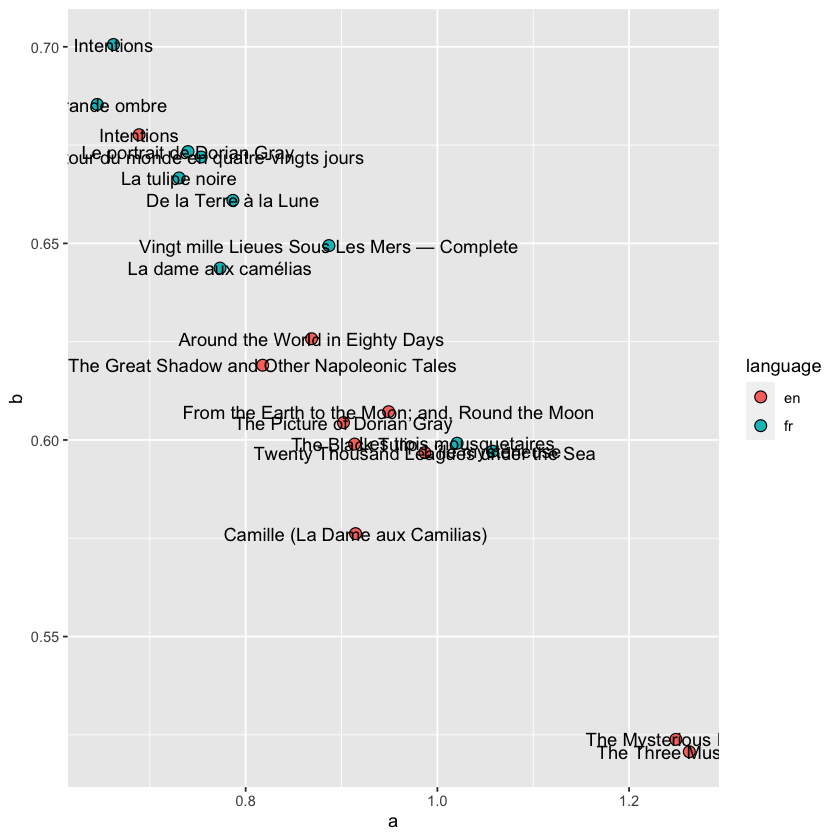

In [51]:
ggplot(df, aes(x = a, y = b, fill = language, label=title)) +
geom_point(size =3, shape=21) + 
geom_text()

In [52]:
cor.test(df[df$language == "en",]$b, df[df$language == "fr",]$b, method=c("pearson"))


	Pearson's product-moment correlation

data:  df[df$language == "en", ]$b and df[df$language == "fr", ]$b
t = 10.488, df = 8, p-value = 5.942e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8566268 0.9920540
sample estimates:
      cor 
0.9655039 


Wyniki odbiegają o kilka setnych, ponownie obserwujemy korelację